In [1]:
from CASBI.utils.create_dataframe import rescale 
from CASBI.generator.fff.fff_model import FreeFormFlow

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import gaussian_kde

import torch

In [2]:
data = pd.read_parquet('../../data/dataframe/dataframe.parquet')
data =  data.drop(['a','redshift', 'mean_FeMassFrac', 'std_FeMassFrac', 'mean_OMassFrac', 'std_OMassFrac'], axis=1)

# data = rescale(df=data, mean_and_std_path='../../data/preprocess', inverse=True, save=False, scale_observations=True)

# mean_and_std_df = pd.read_parquet('../../MW_MH/data/preprocessing_subsample/mean_and_std_preprocessing.parquet')
# data = utils.rescale(data, mean_and_std_path='../../MW_MH/data/preprocessing_subsample/mean_and_std_preprocessing.parquet', inverse=True)
print('Number of Galaxy: ',len(data['Galaxy_name'].unique()))

Number of Galaxy:  4401


In [3]:
# sample_halo_name = data['Galaxy_name'].sample(250)
sample_halo = data[data['Galaxy_name'].isin(['g2.41e11.00608', 'g2.39e10.00992', 'g2.39e11.00896', 'g1.17e10.00704'])]
sample_halo

feh       ofe  star_log10mass  gas_log10mass  dm_log10mass  \
100000  0.109944 -1.751602       -1.004847      -1.358613     -0.892610   
100001  0.043855 -0.710890       -1.004847      -1.358613     -0.892610   
100002 -0.376113 -0.486254       -1.004847      -1.358613     -0.892610   
100003  0.073114 -1.656394       -1.004847      -1.358613     -0.892610   
100004  0.708241 -1.797292       -1.004847      -1.358613     -0.892610   
...          ...       ...             ...            ...           ...   
796606  1.409802  0.163071        1.346600       1.261901      1.282584   
796607  1.135891  0.359481        1.346600       1.261901      1.282584   
796608 -0.479115  0.467999        1.346600       1.261901      1.282584   
796609  1.622792  0.200629        1.346600       1.261901      1.282584   
796610 -0.406052  0.431047        1.346600       1.261901      1.282584   

        infall_time  mean_metallicity  std_metallicity     Galaxy_name  
100000     0.630358         -0.509486        -0.492433  g1.17e10.00704  
100001     0.630358         -0.509486        -0.492433  g1.17e10.00704  
100002     0.630358         -0.509486        -0.492433  g1.17e10.00704  
100003     0.630358         -0.509486        -0.492433  g1.17e10.00704  
100004     0.630358         -0.509486        -0.492433  g1.17e10.00704  
...             ...               ...              ...             ...  
796606     0.285882          1.314420         1.231449  g2.41e11.00608  
796607     0.285882          1.314420         1.231449  g2.41e11.00608  
796608     0.285882          1.314420         1.231449  g2.41e11.00608  
796609     0.285882          1.314420         1.231449  g2.41e11.00608  
796610     0.285882          1.314420         1.231449  g2.41e11.00608  

[2000 rows x 9 columns]

In [21]:
def plot_halo(df_halo:pd.DataFrame, data:pd.DataFrame):
    """
    Plots the halo data.

    Args:
        df_halo (pd.DataFrame): The halo data containing galaxy names, [Fe/H], and [O/Fe].
        data (pd.DataFrame): The data set from which [Fe/H] and [O/Fe] ranges are extracted to set the boundaries of the plots and the returned histogram

    Returns:
        tuple: A tuple containing the histogram, x-edges, and y-edges.
    """
    # from matplotlib.backends.backend_pdf import PdfPages
    # Create a new PDF file
    # pdf_pages = PdfPages('halo.pdf')
    
    min_feh, max_feh = min(data['feh']), max(data['feh'])
    min_ofe, max_ofe = min(data['ofe']), max(data['ofe'])
    fig = plt.figure(figsize=(28,10), layout='tight')
    fontsize = 28
    labelsize = 28
    ax = fig.add_subplot(121)
    colors = ['blue', 'green', 'purple', 'orange']
    for i, name in enumerate(sorted(df_halo['Galaxy_name'].unique())):
        ax.scatter(df_halo[df_halo['Galaxy_name']==name]['feh'], df_halo[df_halo['Galaxy_name']==name]['ofe'], label=name, s=6, c=colors[i])
    ax.set_xlabel('[Fe/H]', fontsize=fontsize)
    ax.set_ylabel('[O/Fe]', fontsize=fontsize)
    ax.tick_params(axis='both', which='major', labelsize=labelsize)
    ax.set_xlim((min_feh, max_feh))
    ax.set_ylim((min_ofe, max_ofe))
    # ax.legend(bbox_to_anchor=(-0.60, 1), loc='upper left')
    ax.legend(loc='lower left', fontsize=fontsize)
        
    ax = fig.add_subplot(122)
    feh_ofe = df_halo[['feh', 'ofe']].values
    num_bins=65
    #with density=True the integral is equal to one, so also the support needs to be multiply
    hist, xedges, yedges = np.histogram2d(feh_ofe[:,0], feh_ofe[:,1], bins=num_bins, range=[[min_feh, max_feh], [min_ofe, max_ofe]])
    # hist, xedges, yedges, im = ax.hist2d(x=fake_halo['feh'], y=fake_halo['ofe'], bins=50, cmap='magma');
    im = ax.imshow(np.log10(hist.T), origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto', cmap='magma')
    # for name in df_halo['Galaxy_name'].unique():
    #     ax.scatter(df_halo[df_halo['Galaxy_name']==name]['feh'], df_halo[df_halo['Galaxy_name']==name]['ofe'], label=name, s=0.1)
    
    ax.set_xlabel('[Fe/H]', fontsize=fontsize)
    ax.set_ylabel('[O/Fe]', fontsize=fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    cbar = fig.colorbar(im, ax=ax, label='Counts')
    cbar.set_label('Counts', size=fontsize)
    # pdf_pages.savefig()
    # Close the PDF file
    # pdf_pages.close()
    fig.savefig('halo.png')
    return hist, xedges, yedges

/tmp/ipykernel_3960400/3044851572.py:39: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(hist.T), origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto', cmap='magma')


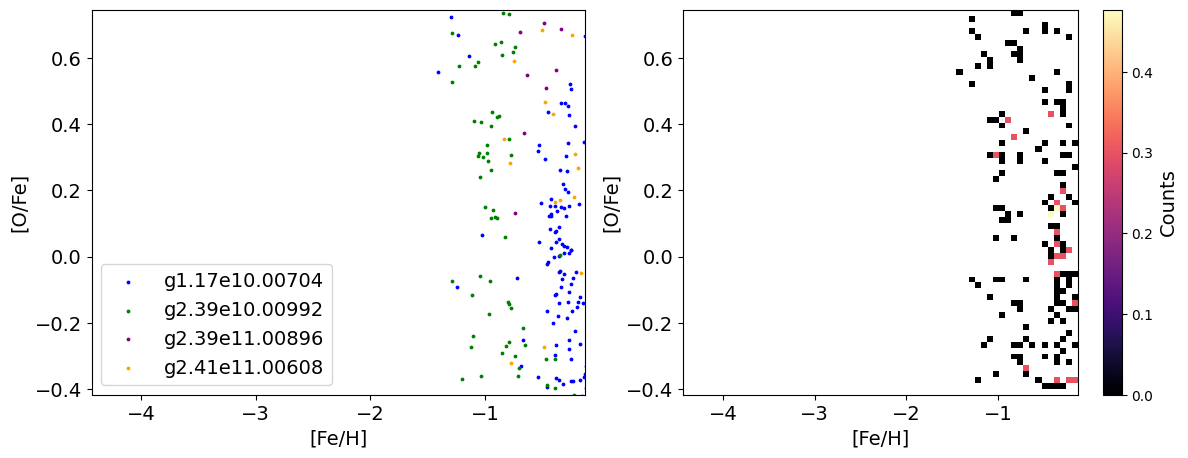

In [7]:
hist, xdges, yedges = plot_halo(df_halo=sample_halo, data=data)

In [9]:
plt.hist(hist.reshape(50**2));
plt.xlabel('Counts')

ValueError: cannot reshape array of size 4225 into shape (2500,)

In [9]:
def gen_conditions(conditions, n_bins=100, halo_number=int):
    """Generate sample conditions based on given conditions, taking into account correlations between conditions.

    Args:
        conditions (pandas.DataFrame): The conditions to generate sample conditions from.
        n_bins (int, optional): The number of bins to use for generating sample conditions. Defaults to 100.

    Returns:
        dict: The generated sample conditions.

    """
    
    bin_mass = (max(conditions['star_log10mass'].values) - min(conditions['star_log10mass'].values))/n_bins
    kde = gaussian_kde(conditions['star_log10mass'])
    star_mass = kde.resample(1)[0][0]
    sample_conditions = {'star_log10mass': star_mass}
    
    cut_in_mass = conditions[(star_mass - bin_mass < conditions['star_log10mass']) & (conditions['star_log10mass']<star_mass + bin_mass)]
    conditions_to_sample = cut_in_mass.columns.difference(['star_log10mass', 'infall_time', 'Galaxy_name'], sort=False)
   
    for i, col in enumerate(conditions_to_sample):
        possible_cond = cut_in_mass[col].values
        kde = gaussian_kde(possible_cond)
        sample_conditions[col] = kde.resample(1)[0][0]

    kde = gaussian_kde(conditions['infall_time'])
    infall_time = kde.resample(1)[0][0]
    sample_conditions['infall_time'] = infall_time
    sample_conditions['Galaxy_name'] = f'Generated_galaxy:{halo_number}'
    
    return sample_conditions 


def gen_halo_conditions(n_halos:int, conditions:pd.DataFrame, n_bins:int=100):
    genereated_halo_conditions = pd.DataFrame(columns = conditions.columns)
    
    for n in range(n_halos):
        sample_conditions = gen_conditions(conditions, n_bins=n_bins, halo_number=n)
        genereated_halo_conditions.loc[len(genereated_halo_conditions)] = sample_conditions
    genereated_halo_conditions = genereated_halo_conditions.reindex(columns=conditions.columns)
    return genereated_halo_conditions

In [10]:
conditions = data[data.columns.difference(['feh', 'ofe'], sort=False)]
generated_halo_conditions = gen_halo_conditions(n_halos=4, conditions=conditions, n_bins=10)
generated_halo_conditions

star_log10mass  gas_log10mass  dm_log10mass  infall_time  mean_metallicity  \
0        1.053252       1.278508      1.114844    -0.822046          0.214628   
1       -0.101399       0.121029     -0.379804     0.916316         -0.369481   
2       -1.374714      -1.285438     -0.470285     1.838533         -0.624049   
3        1.158148       1.245410      1.021252     1.441174          0.321603   

   std_metallicity         Galaxy_name  
0         1.562835  Generated_galaxy:0  
1        -0.484291  Generated_galaxy:1  
2        -0.519753  Generated_galaxy:2  
3         0.138079  Generated_galaxy:3

In [14]:
model_snapshot = '../../test_for_fff/best_snapshot.pth'
Flow = FreeFormFlow(dim = 2, 
                    cond_dim = 6,
                    hidden_dim = 128,
                    latent_dim = 2,
                    n_SC_layer = 6,
                    beta = 100,
                    device = 'cuda')

Flow.load_state_dict(torch.load(model_snapshot))


<All keys matched successfully>

In [15]:
def gen_halo(halo_conditions, generator):
    """  
    Generate a halo based on given conditions.
    """

    for i in range(len(halo_conditions)):
        cond = torch.tensor(halo_conditions.iloc[i, :-1].values.astype(float)).float().to('cuda')
        cond = cond.repeat(500, 1)
        halo = generator.sample(500, cond).cpu().detach().numpy()
        if i==0:
            df_halo = pd.DataFrame(halo, columns=['feh', 'ofe'])
            for col in halo_conditions.columns:
                df_halo[col] = halo_conditions[col].iloc[i]
        else:
            halo = pd.DataFrame(halo, columns=['feh', 'ofe'])
            for col in halo_conditions.columns:
                halo[col] = halo_conditions[col].iloc[i]
            df_halo = pd.concat([df_halo, halo]) 
    return df_halo

In [18]:
data = rescale(data, mean_and_std_path='../../data/preprocess/mean_and_std.parquet', inverse=False)


In [43]:
def plot_halo(df_halo:pd.DataFrame, data:pd.DataFrame):
    """
    Plots the halo data.

    Args:
        df_halo (pd.DataFrame): The halo data containing galaxy names, [Fe/H], and [O/Fe].
        data (pd.DataFrame): The data set from which [Fe/H] and [O/Fe] ranges are extracted to set the boundaries of the plots and the returned histogram

    Returns:
        tuple: A tuple containing the histogram, x-edges, and y-edges.
    """
    # from matplotlib.backends.backend_pdf import PdfPages
    # Create a new PDF file
    # pdf_pages = PdfPages('halo.pdf')
    
    min_feh, max_feh = min(data['feh']), max(data['feh'])
    min_ofe, max_ofe = min(data['ofe']), max(data['ofe'])
    fig = plt.figure(figsize=(28*2,10*2), layout='tight')
    fontsize = 30*2
    labelsize = 30*2
    ax = fig.add_subplot(121)
    colors = ['blue', 'green', 'purple', 'orange']
    for i, name in enumerate(sorted(df_halo['Galaxy_name'].unique())):
        ax.scatter(df_halo[df_halo['Galaxy_name']==name]['feh'], df_halo[df_halo['Galaxy_name']==name]['ofe'], label=f'Gen Galaxy {i} ', s=30*4, c=colors[i])
    ax.set_xlabel('[Fe/H]', fontsize=fontsize)
    ax.set_ylabel('[O/Fe]', fontsize=fontsize)
    ax.tick_params(axis='both', which='major', labelsize=labelsize)
    ax.set_xlim((min_feh, max_feh))
    ax.set_ylim((min_ofe, max_ofe))
    # ax.legend(bbox_to_anchor=(-0.60, 1), loc='upper left')
    ax.legend(loc='lower left', fontsize=fontsize)
        
    ax = fig.add_subplot(122)
    feh_ofe = df_halo[['feh', 'ofe']].values
    num_bins=65
    #with density=True the integral is equal to one, so also the support needs to be multiply
    hist, xedges, yedges = np.histogram2d(feh_ofe[:,0], feh_ofe[:,1], bins=num_bins, range=[[min_feh, max_feh], [min_ofe, max_ofe]])
    # hist, xedges, yedges, im = ax.hist2d(x=fake_halo['feh'], y=fake_halo['ofe'], bins=50, cmap='magma');
    im = ax.imshow(np.log10(hist.T), origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto', cmap='magma')
    # for name in df_halo['Galaxy_name'].unique():
    #     ax.scatter(df_halo[df_halo['Galaxy_name']==name]['feh'], df_halo[df_halo['Galaxy_name']==name]['ofe'], label=name, s=0.1)
    
    ax.set_xlabel('[Fe/H]', fontsize=fontsize)
    ax.set_ylabel('[O/Fe]', fontsize=fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    cbar = fig.colorbar(im, ax=ax, label='Counts')
    cbar.ax.tick_params(labelsize=fontsize)  # Set tick label size
    cbar.set_label('Counts', size=fontsize)
    # pdf_pages.savefig()
    # Close the PDF file
    # pdf_pages.close()
    fig.savefig('halo.png')
    return hist, xedges, yedges

/tmp/ipykernel_4048899/3293280471.py:39: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(hist.T), origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto', cmap='magma')


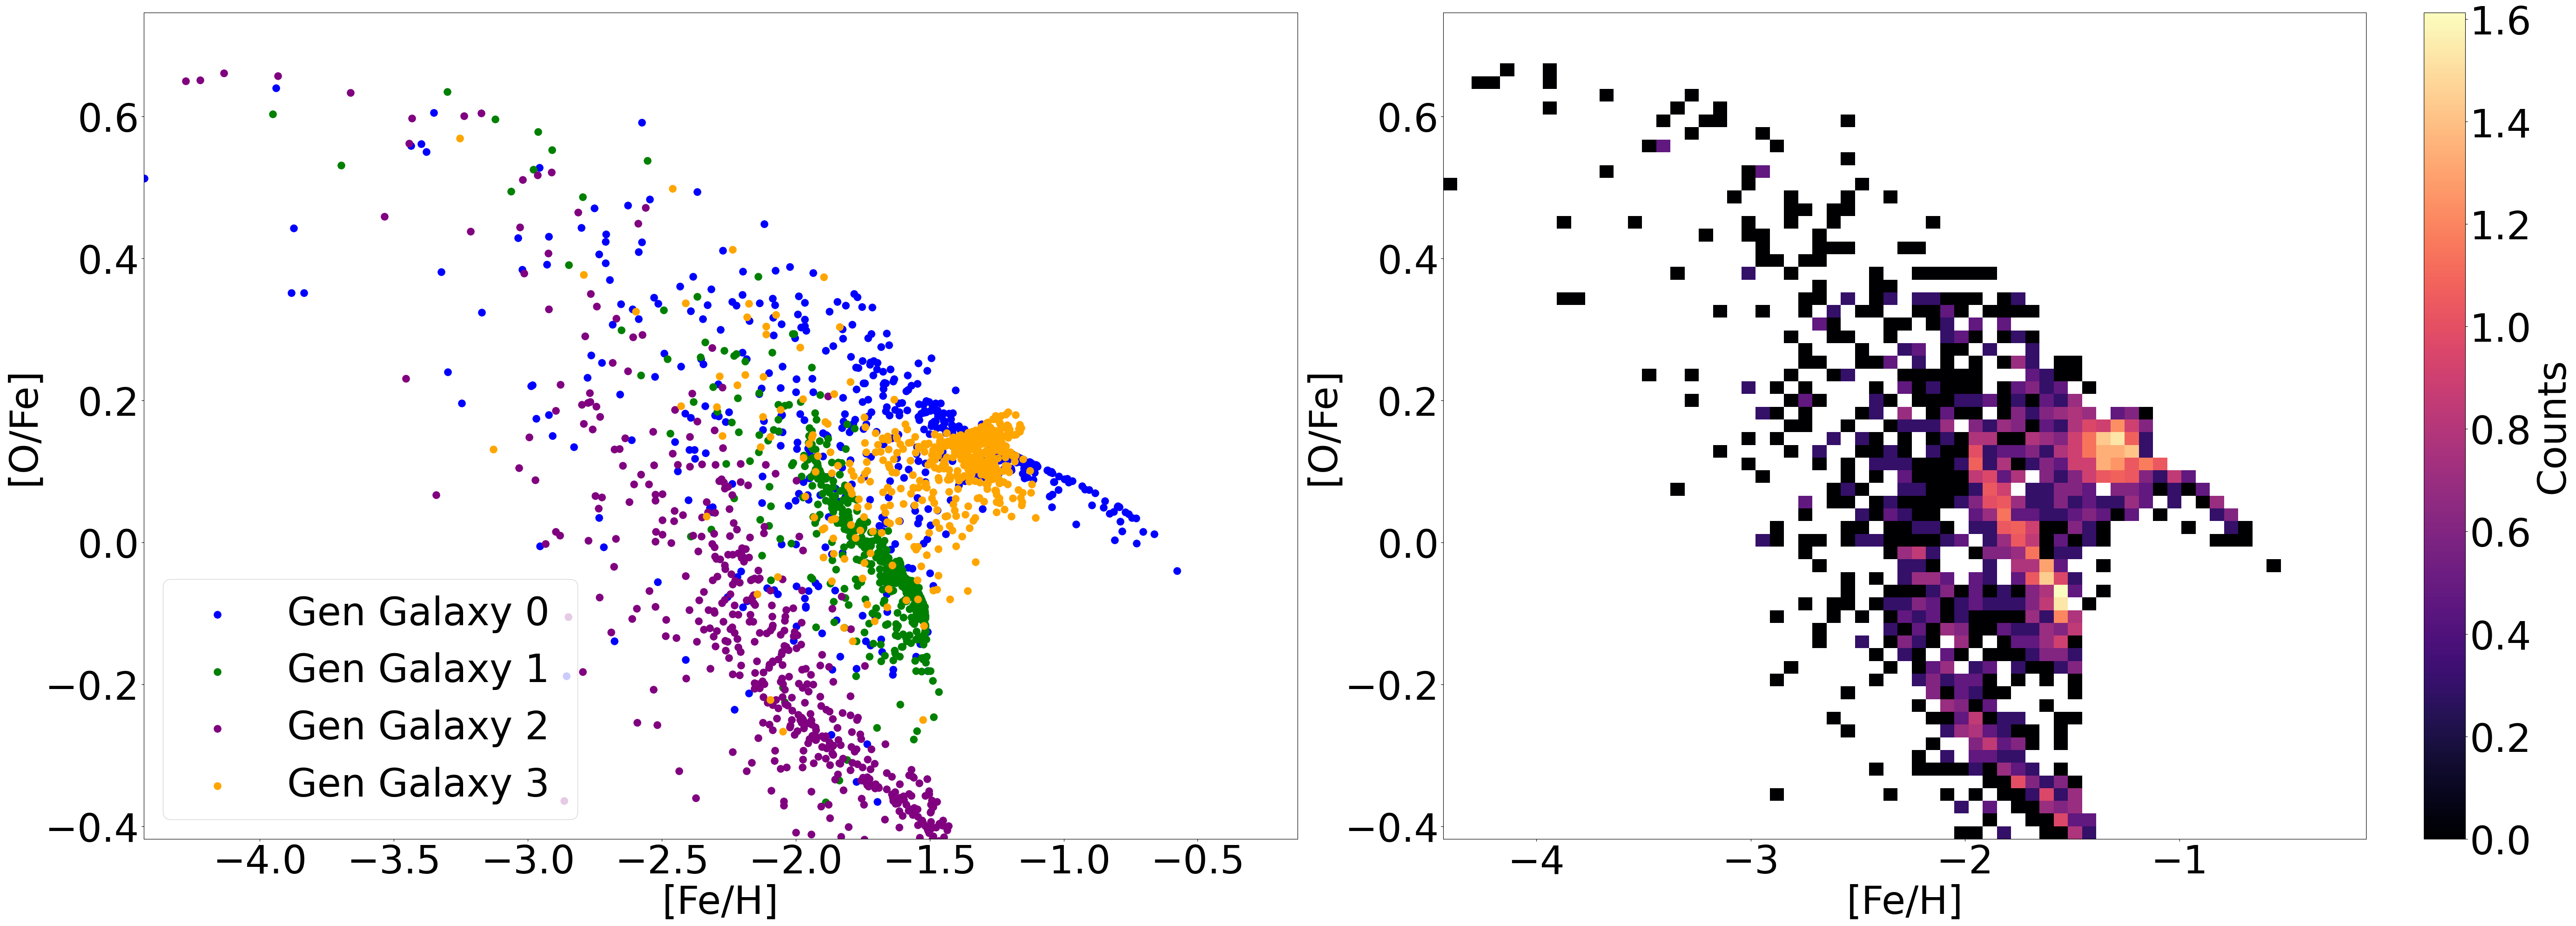

In [44]:
# generated_halo_conditions = gen_halo_conditions(n_halos=4, conditions=conditions, n_bins=10)
# df_halo = gen_halo(generated_halo_conditions, Flow)
# df_halo = rescale(df_halo, mean_and_std_path='../../data/preprocess/mean_and_std.parquet', inverse=True) 
plot_halo(df_halo=df_halo, data=data);

/tmp/ipykernel_1874029/3917976080.py:37: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(hist.T), origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto', cmap='magma')


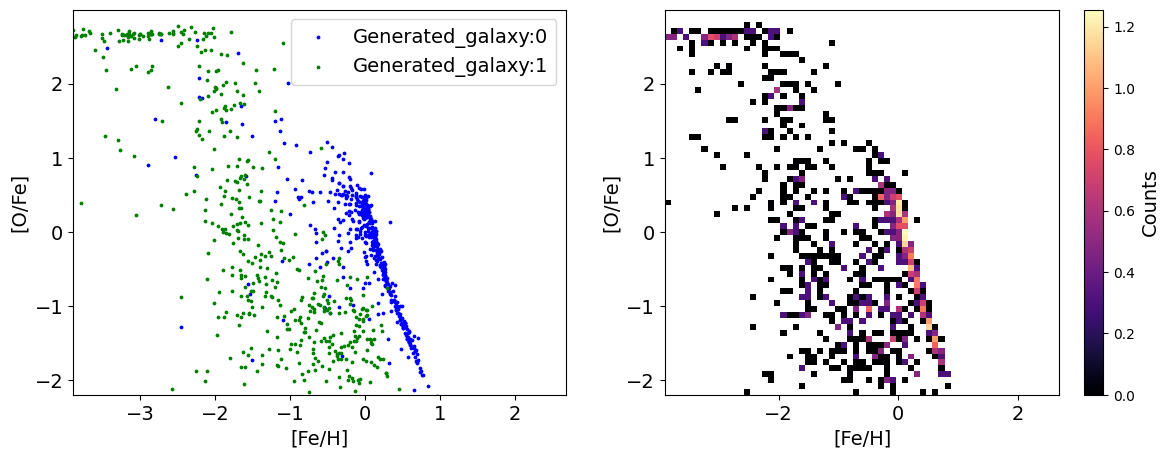

In [31]:
conditions = data[data.columns.difference(['feh', 'ofe'], sort=False)]
generated_halo_conditions = gen_halo_conditions(n_halos=2, conditions=conditions, n_bins=10)
df_halo = gen_halo(generated_halo_conditions, Flow)
plot_halo(df_halo=df_halo, data=data);

In [56]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

fig, axs = plt.subplots(4, 3, figsize=(6*10, 8*10))
fontsize = 100
x = np.linspace(-10, 10, 1000)
colors = ['blue', 'green', 'purple', 'orange']
for i in range(4):
    for j in range(3):
        mean = np.random.rand() * 10 - 5  # Random mean between -5 and 5
        std_dev = np.random.rand() * 2 + 1  # Random std deviation between 1 and 3
        y = norm.pdf(x, loc=mean, scale=std_dev)
        axs[i, j].plot(x, y,color=colors[i], label=f'Prior Gen Galaxy:{i}', linewidth=30)
        axs[i, j].set_yticks([])  
        axs[i, j].set_xlabel(f'$\\theta_{{{j}}}^{i}$', fontsize=fontsize)
        axs[i, j].tick_params(axis='both', which='major', labelsize=fontsize)
        axs[i, j].legend(fontsize=fontsize-40)

plt.tight_layout()
plt.savefig('prior.png')
plt.show()

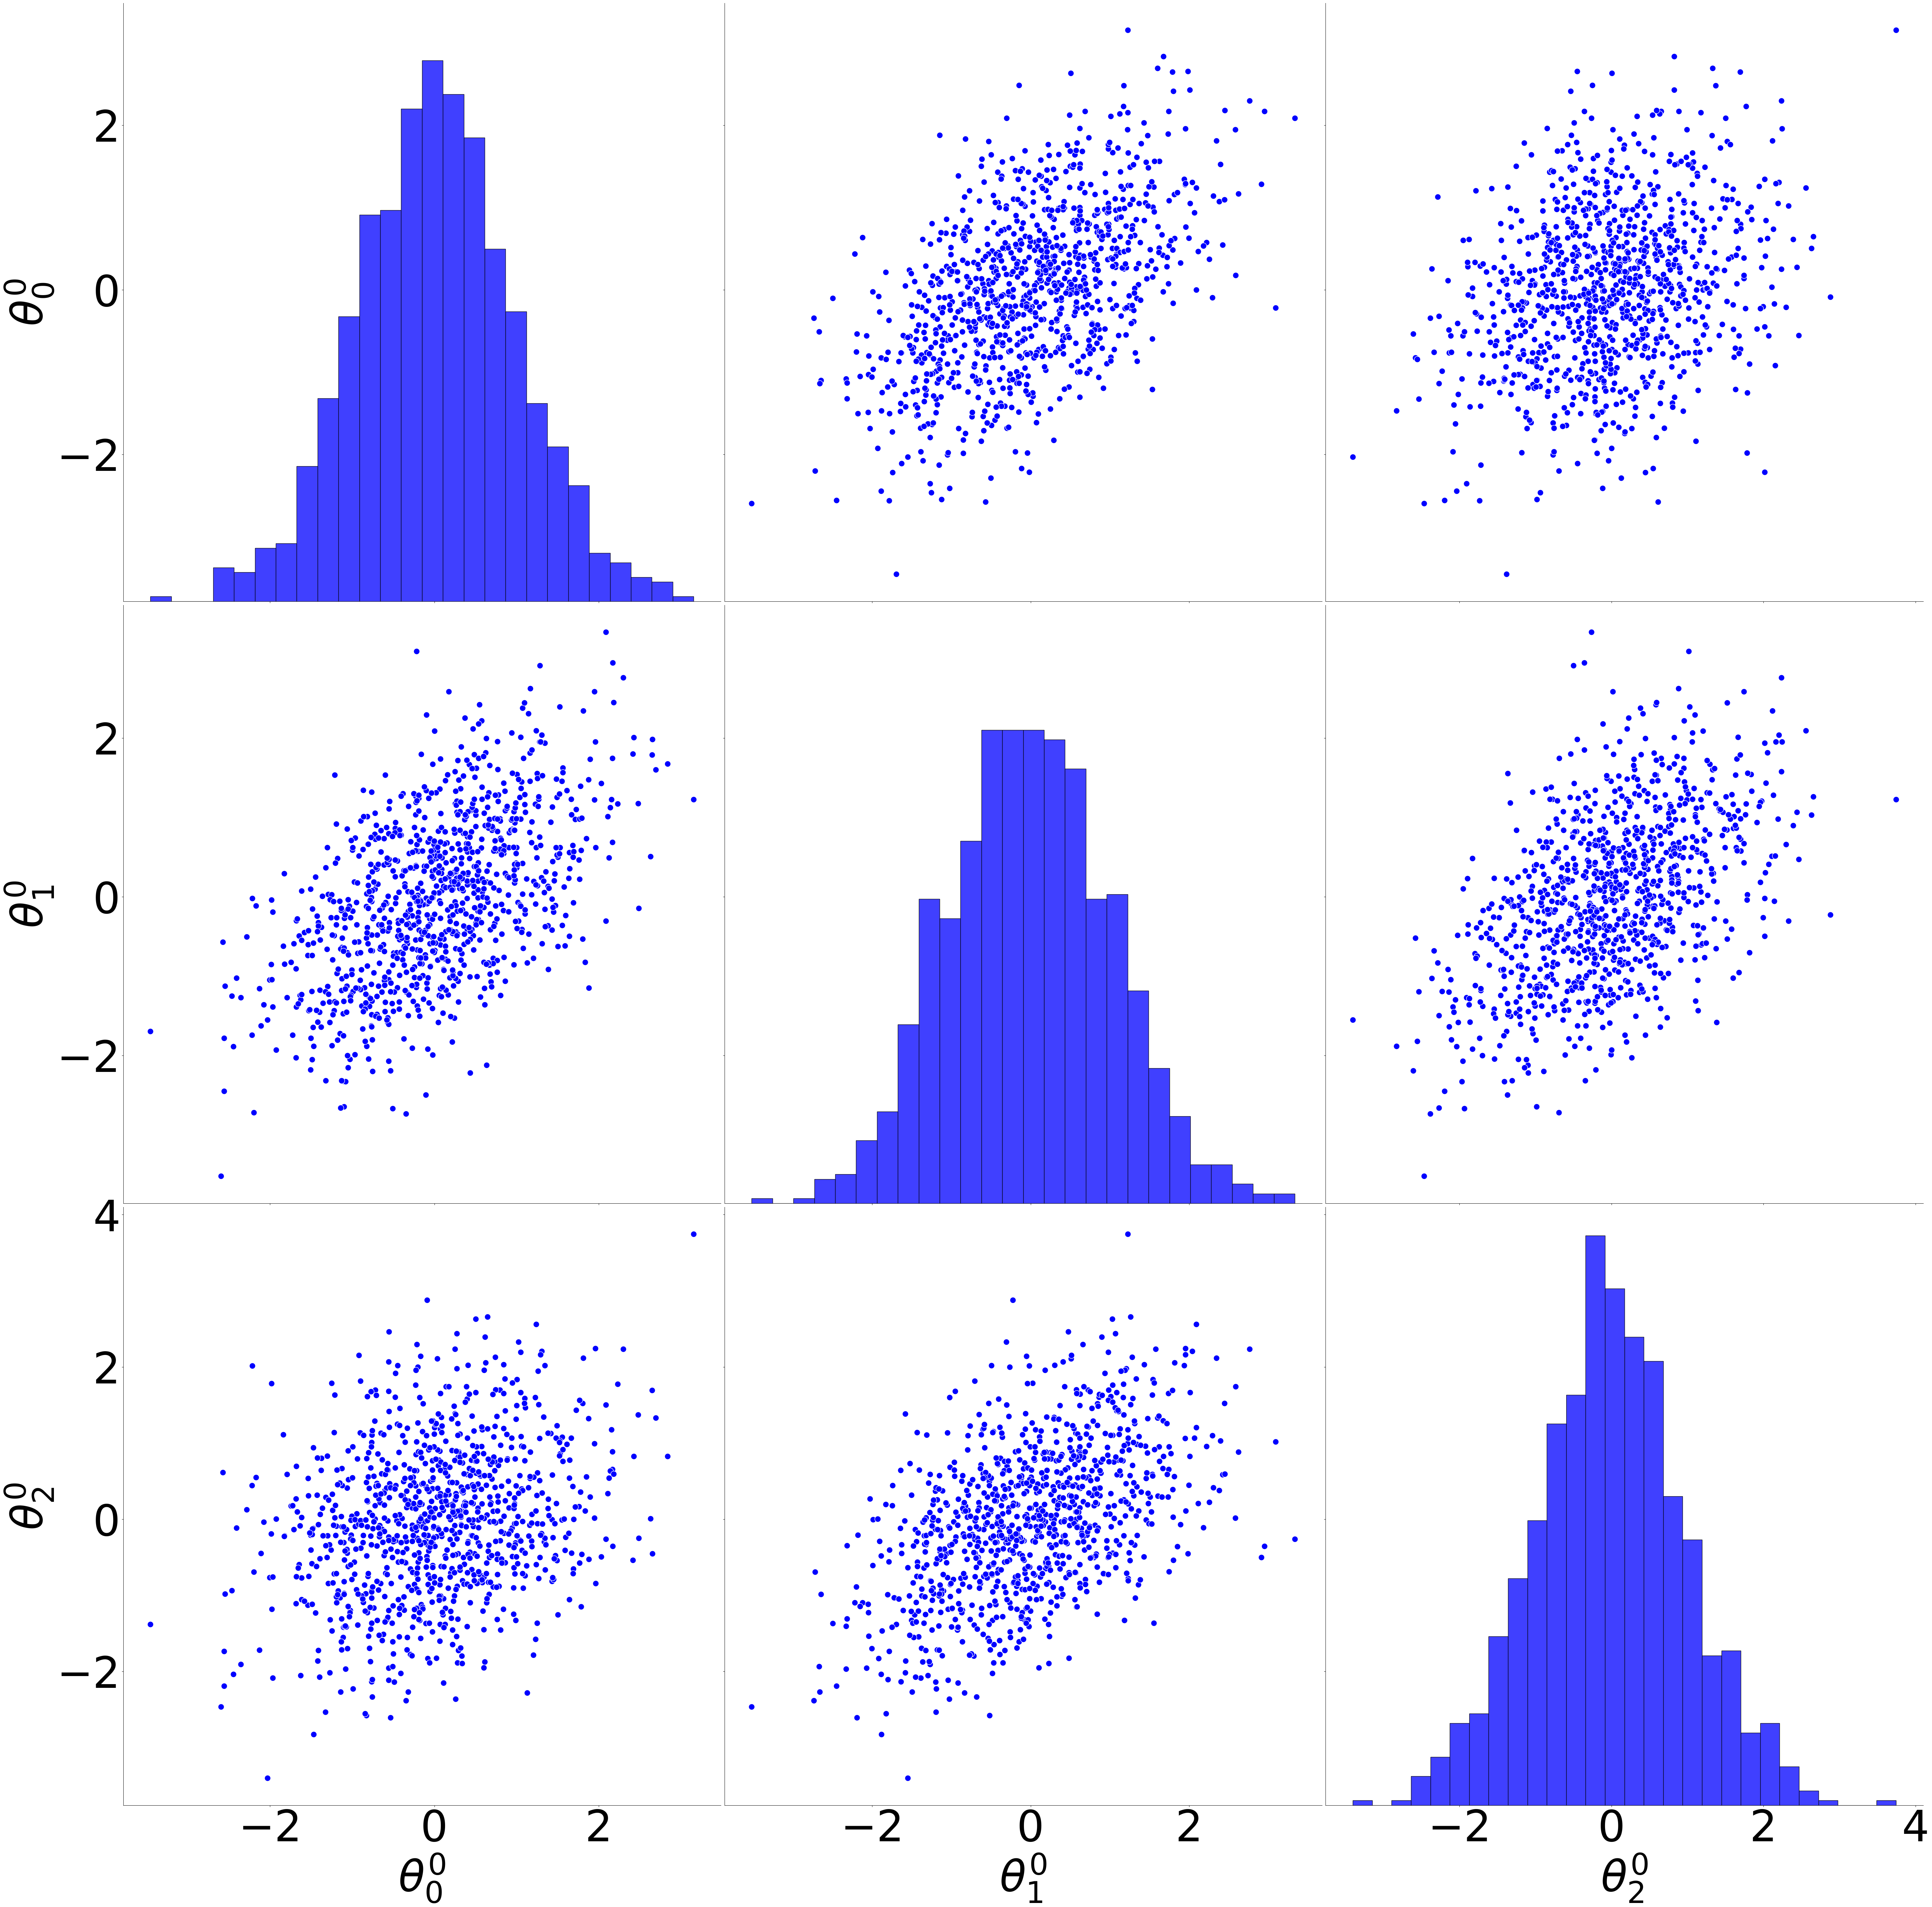

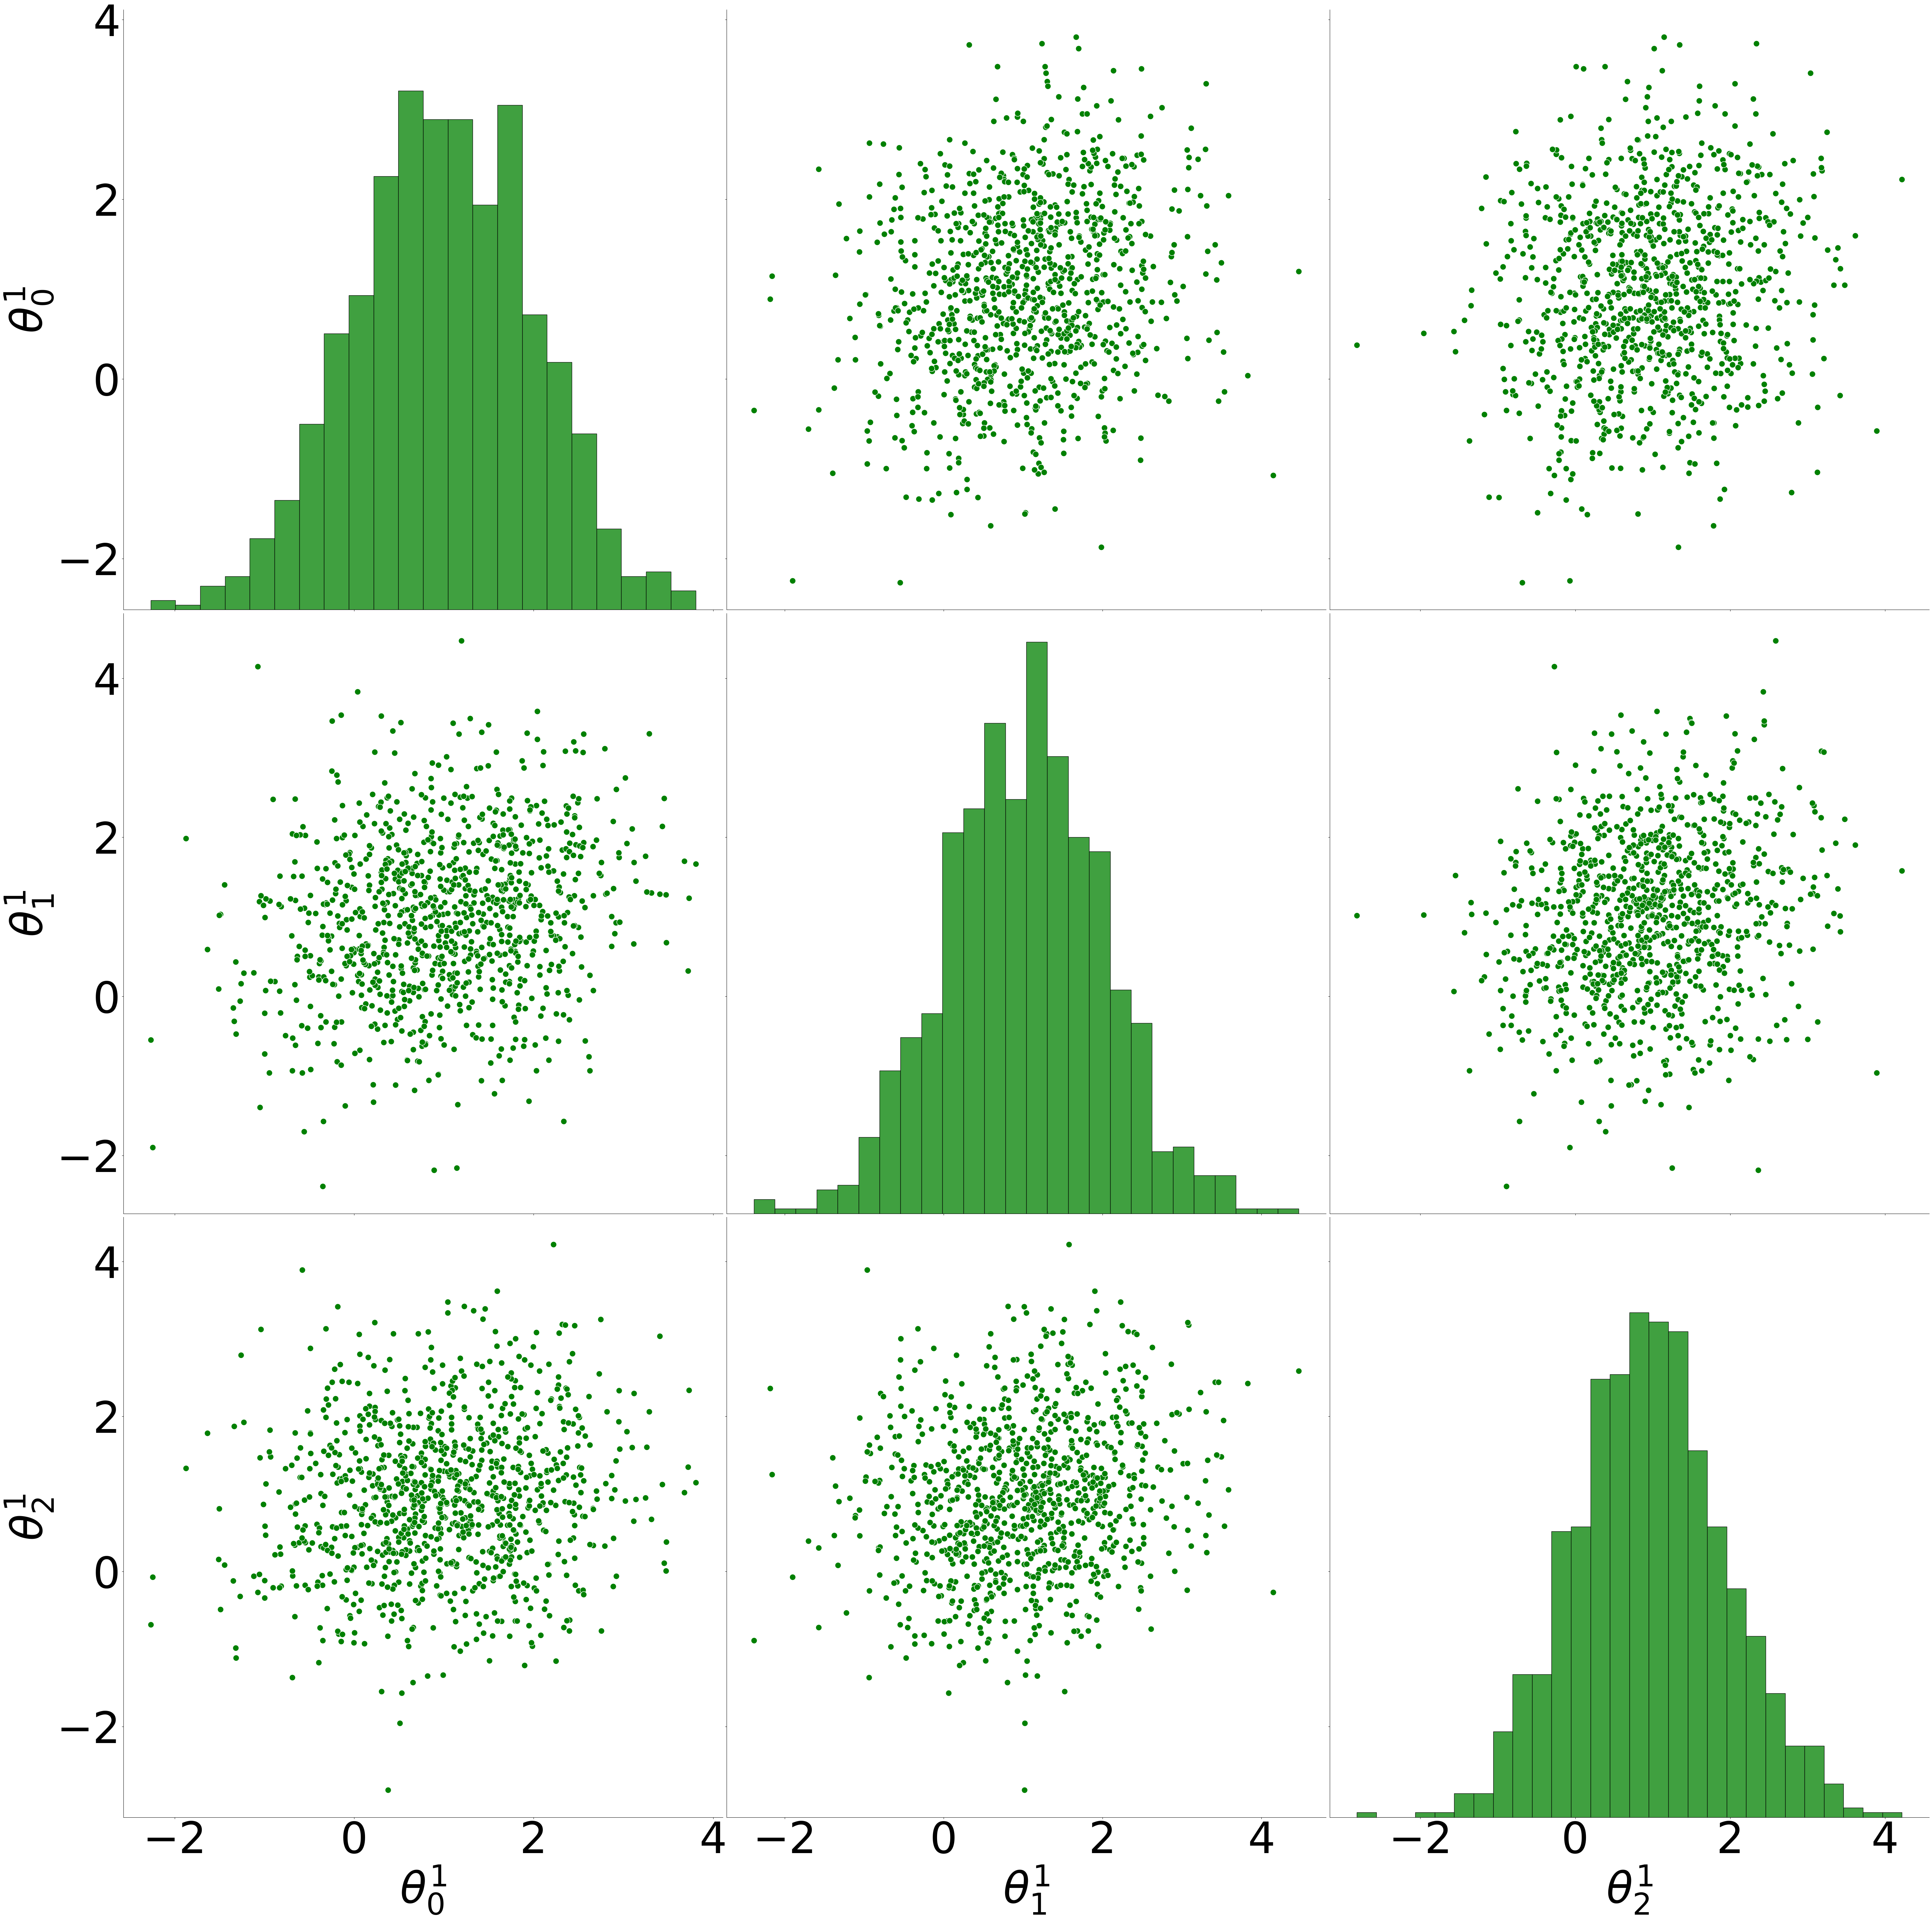

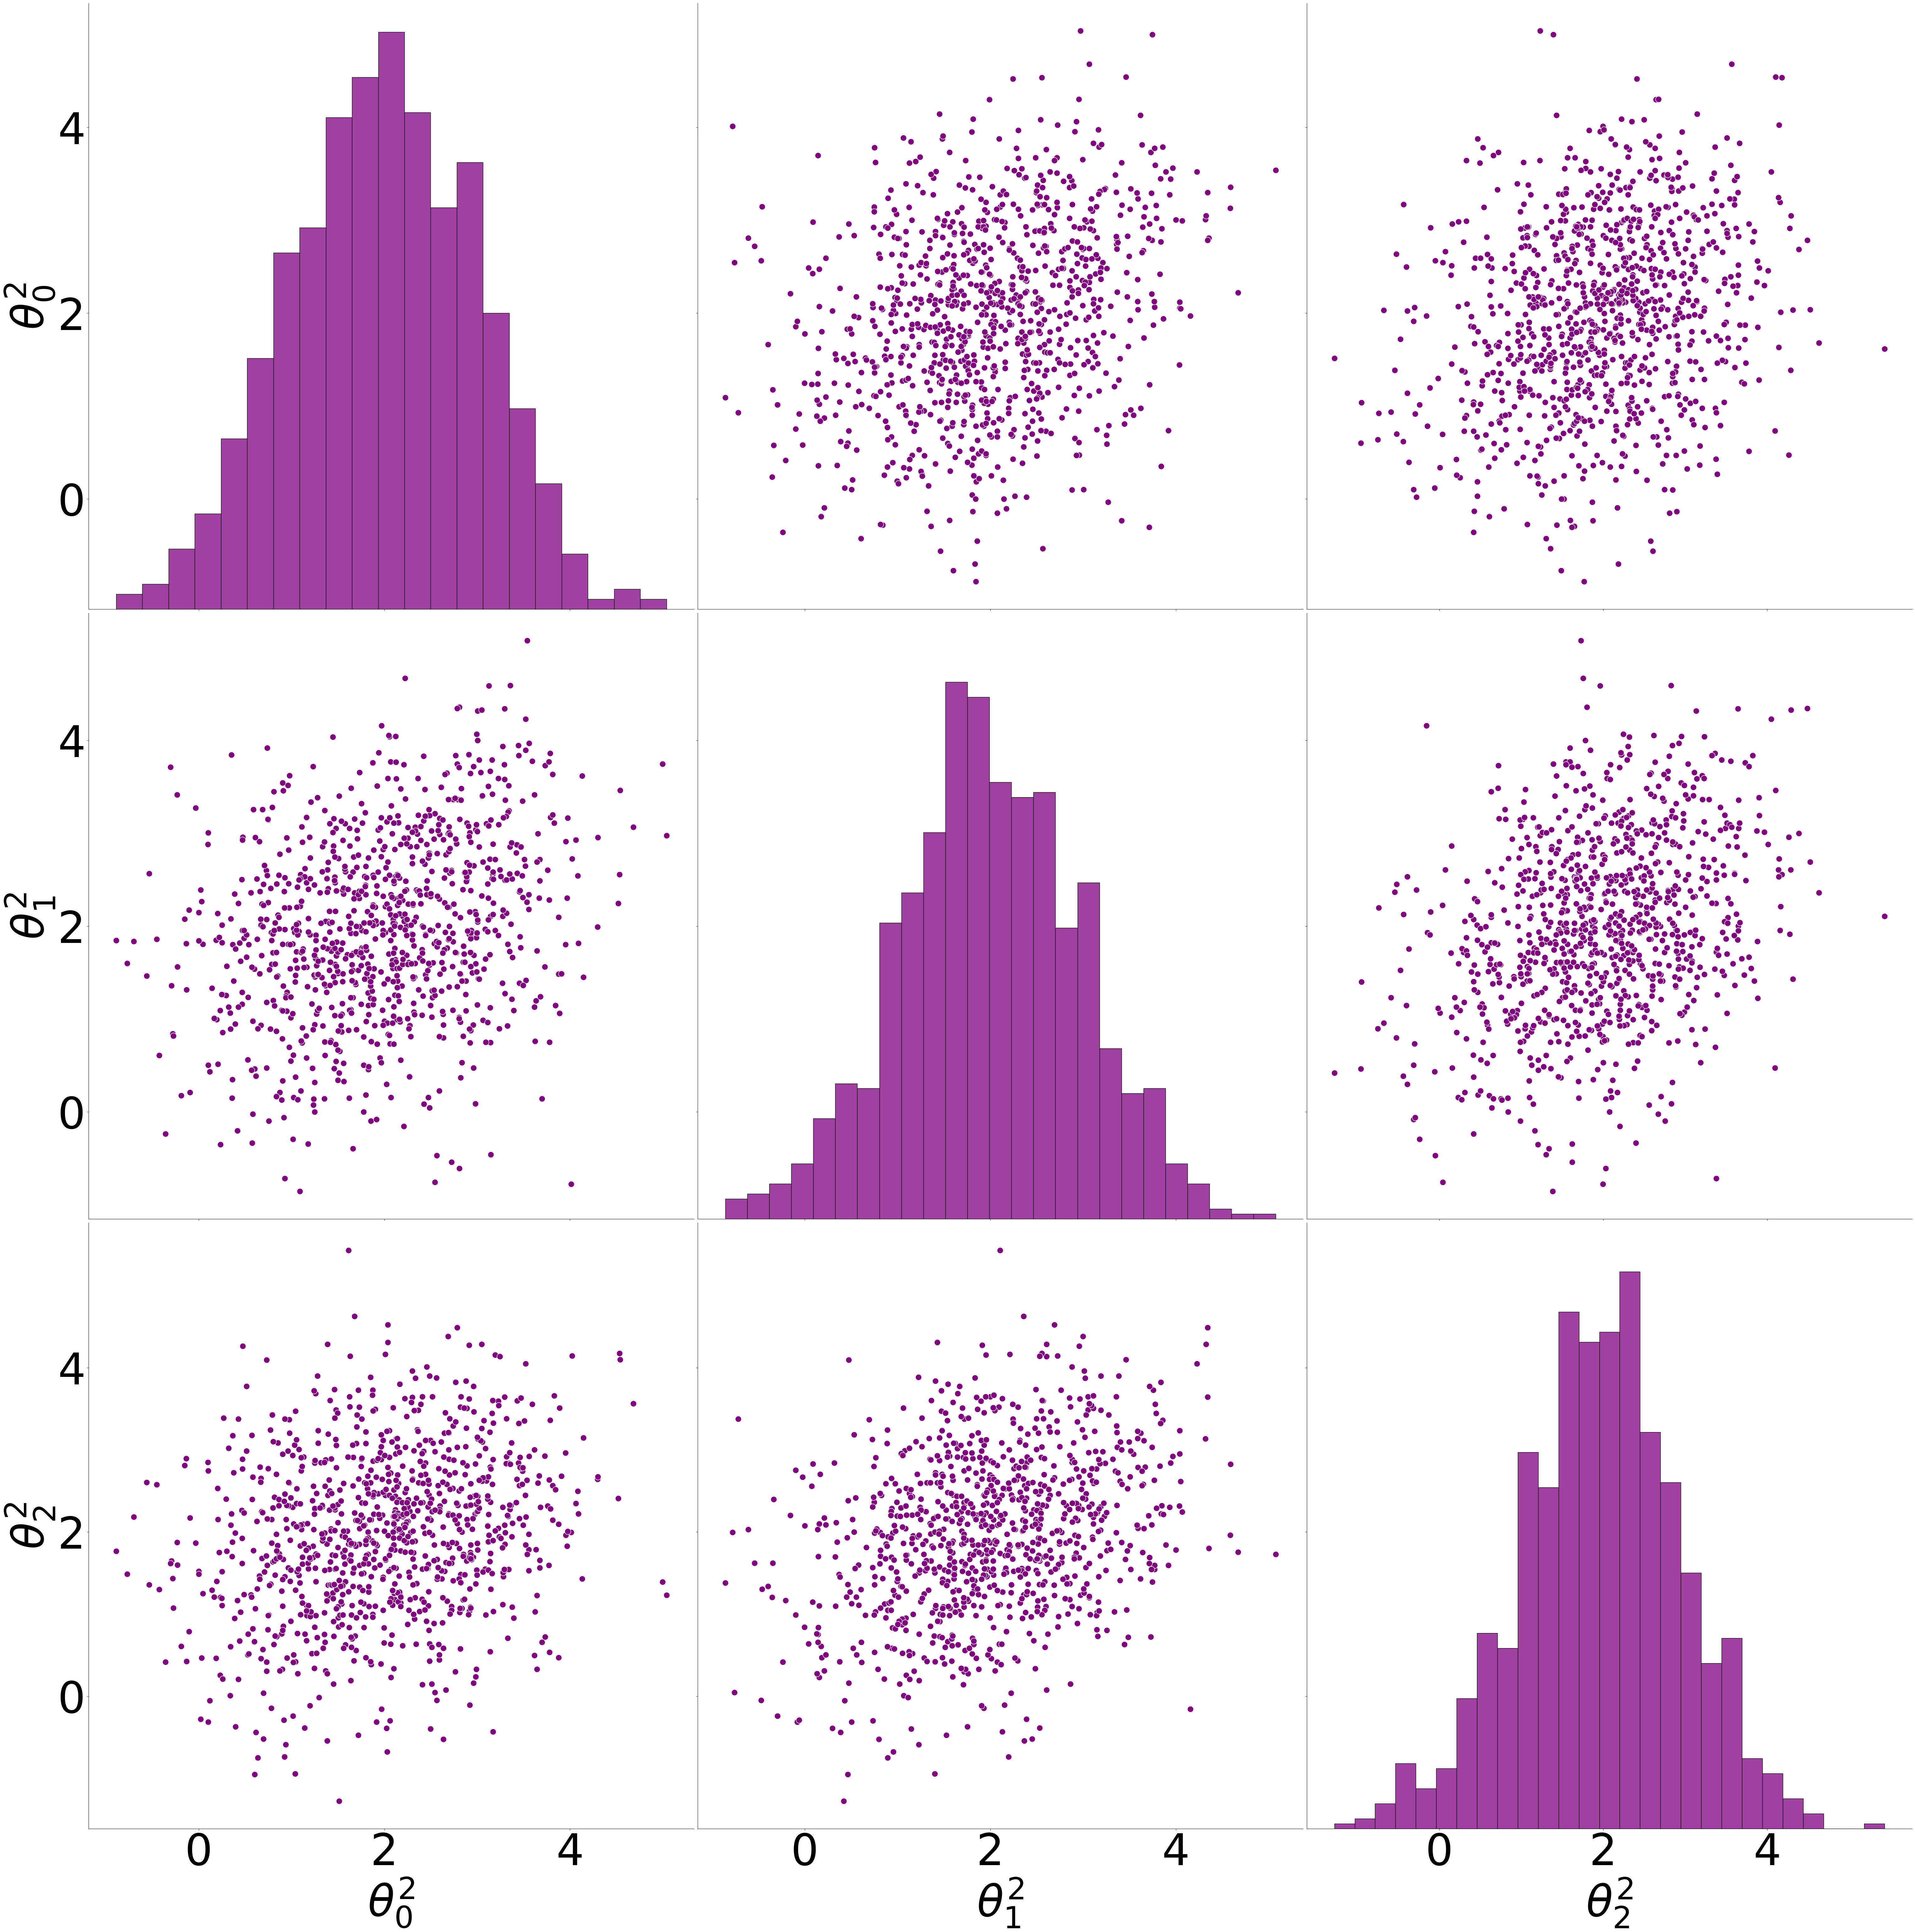

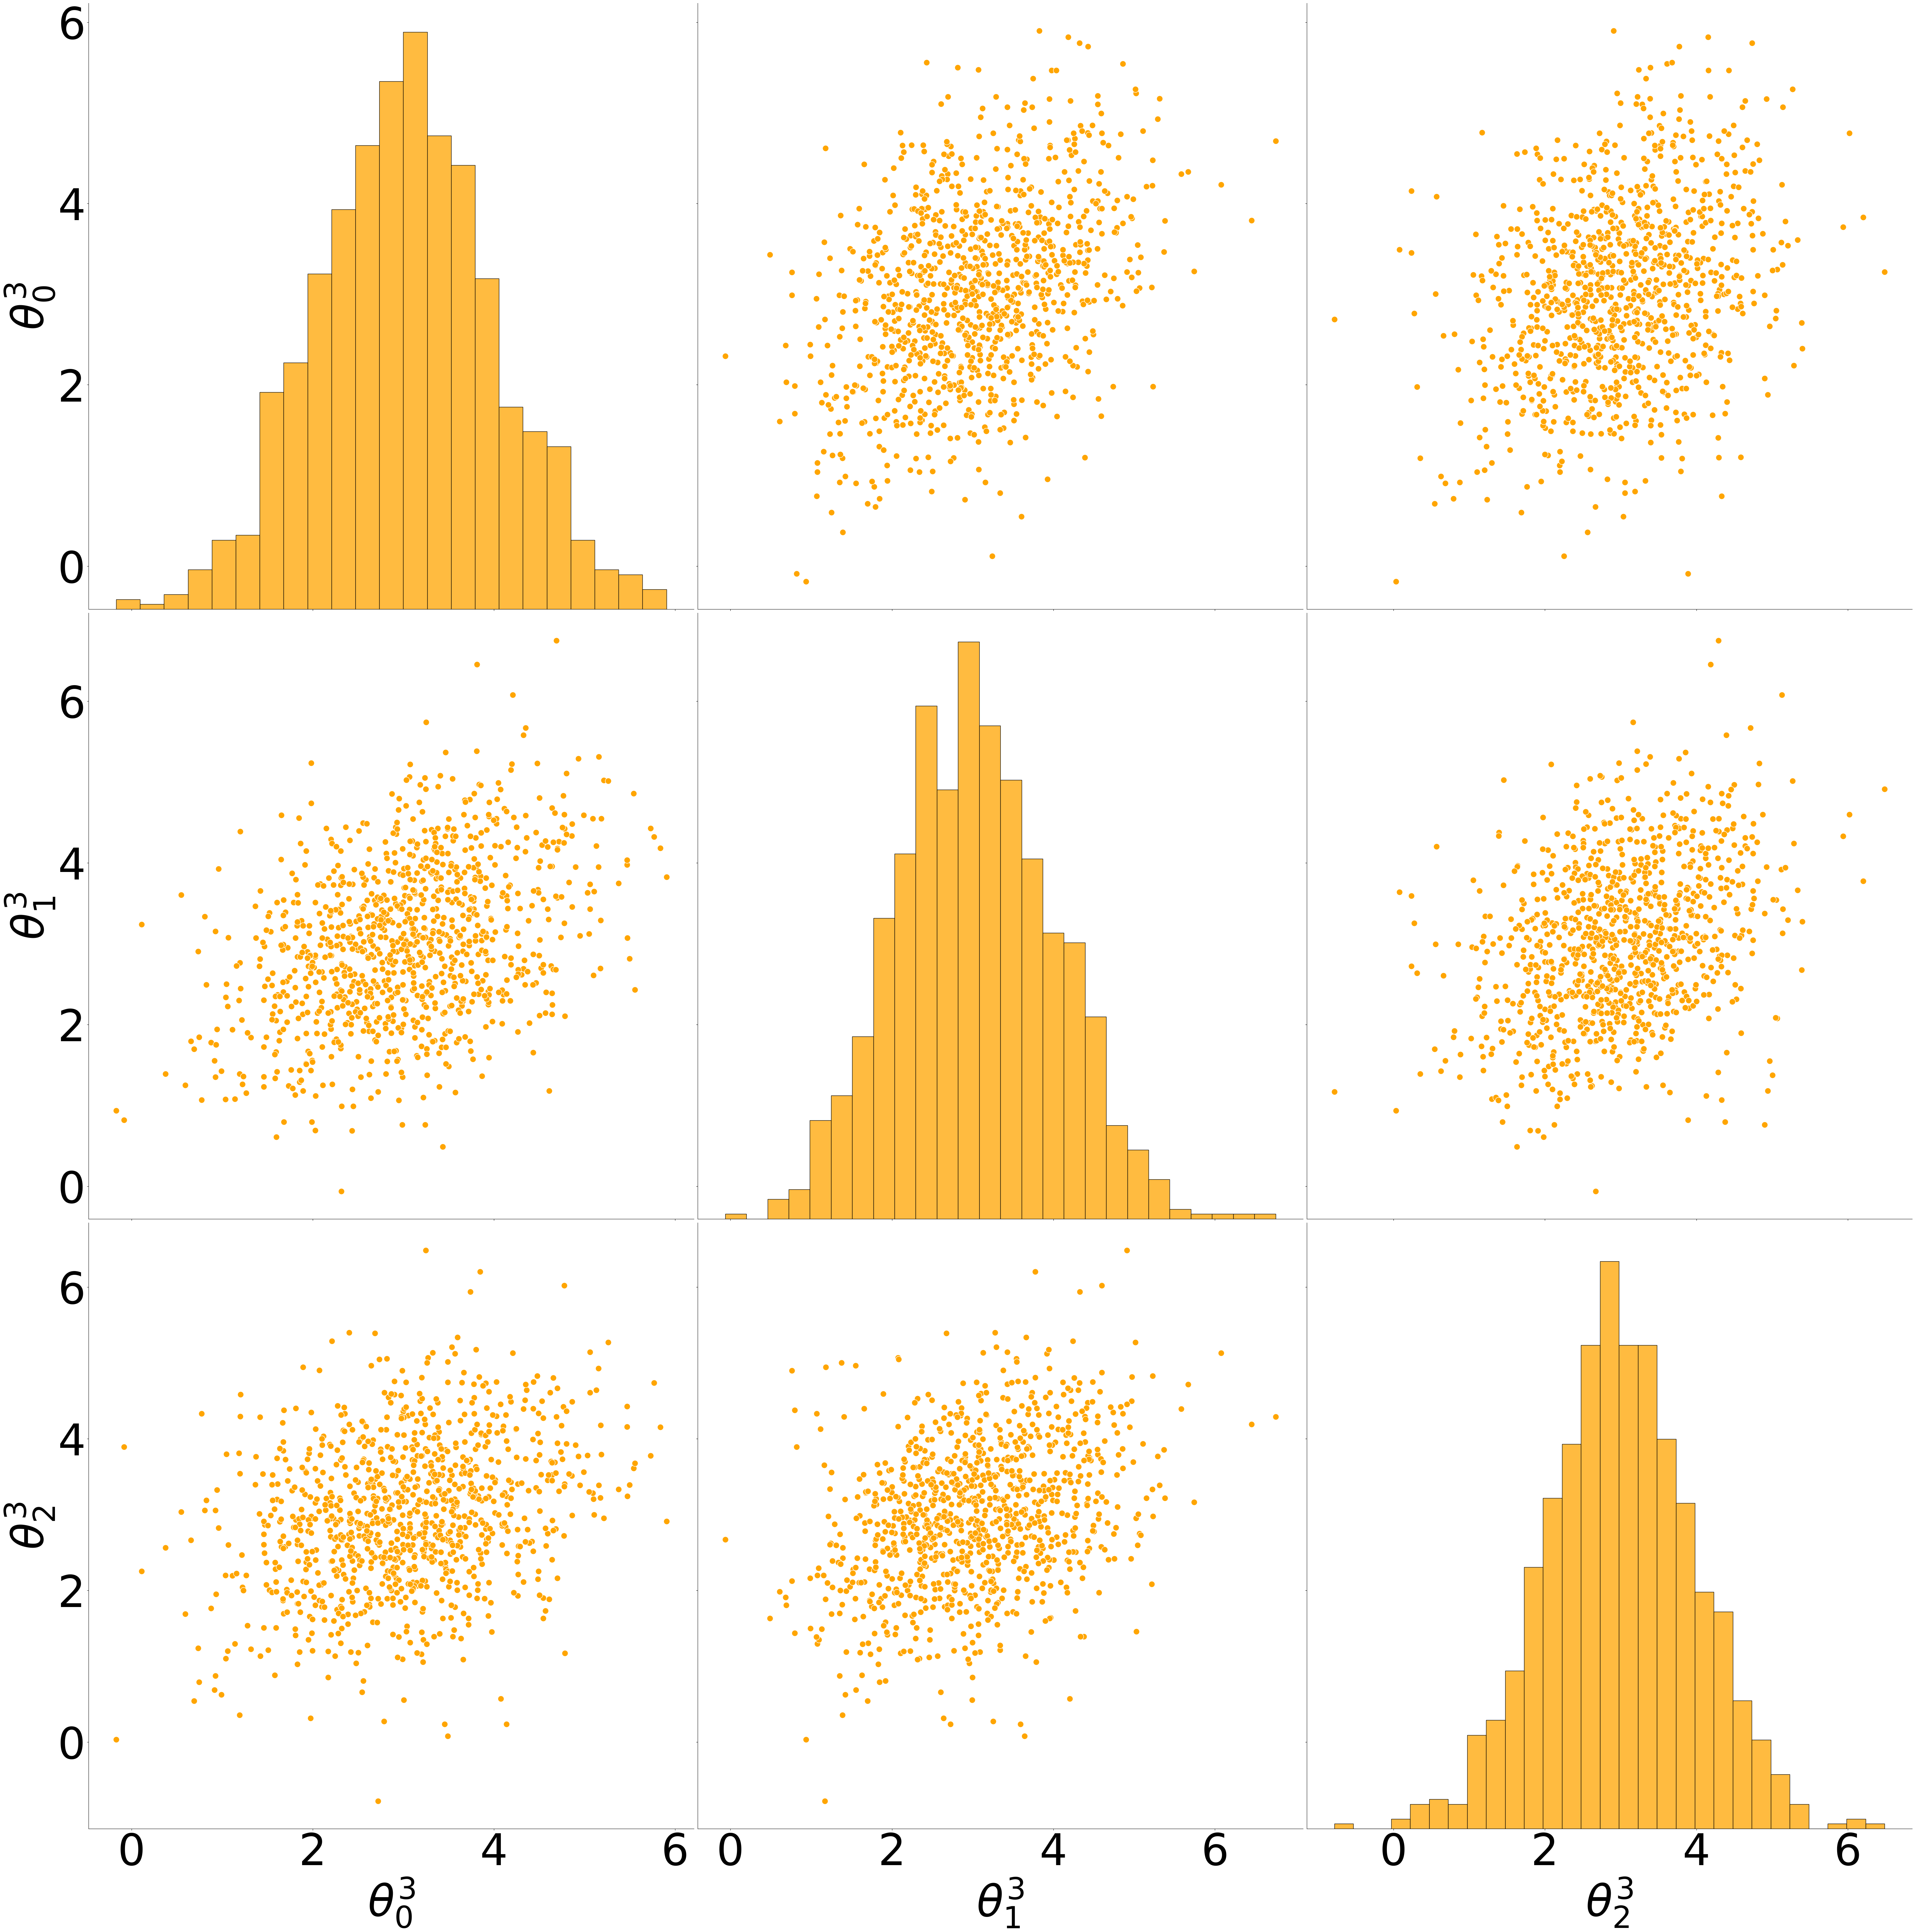

In [54]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

colors = ['blue', 'green', 'purple', 'orange']

# Define the mean and covariance matrices for the multivariate normal distributions
means = [[0, 0, 0], [1, 1, 1], [2, 2, 2], [3, 3, 3]]
covs = [[[1, 0.5, 0.3], [0.5, 1, 0.5], [0.3, 0.5, 1]],
        [[1, 0.2, 0.1], [0.2, 1, 0.2], [0.1, 0.2, 1]],
        [[1, 0.3, 0.2], [0.3, 1, 0.3], [0.2, 0.3, 1]],
        [[1, 0.4, 0.3], [0.4, 1, 0.4], [0.3, 0.4, 1]]]

fontsize=100
# Create a pair plot for each dataset
for i in range(4):
    df = pd.DataFrame(np.random.multivariate_normal(means[i], covs[i], 1000), columns=[f'$\\theta_{{{j}}}^{i}$' for j in range(3)])
    g = sns.pairplot(df, plot_kws={'color': colors[i], 's': 200}, diag_kws={'color': colors[i]}, height=20)
    for ax in g.axes.flatten():
        ax.tick_params(axis='both', which='major', labelsize=fontsize)  # Change tick label size
        ax.xaxis.label.set_size(fontsize)  # Change x-axis label size
        ax.yaxis.label.set_size(fontsize)
    plt.savefig(f'pairplot_{i}.png', bbox_inches='tight')  # Save the plot
    plt.show()